# Wavenet Demo
Demo of our efficient generation implementation.

Trains wavenet on a single wav file. Then generates that file, starting from a single sample.

Starting model 1 on 1, with 2 blocks, 12 layers, 256 dilatation and 909ishShortBeautyKick as wav file
The number of sample is (10570,)
The sample rate is 11025
Train step : 25 & training time is 12.699992895126343 seconds.
Train step : 50 & training time is 23.370573043823242 seconds.


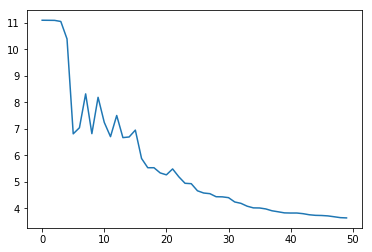

Train step : 75 & training time is 34.045612812042236 seconds.
Train step : 100 & training time is 44.74283766746521 seconds.


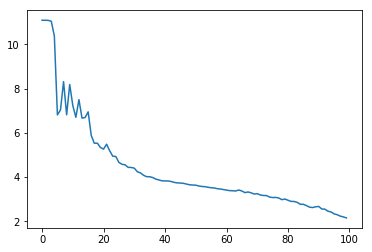

Train step : 125 & training time is 55.573726177215576 seconds.
Train step : 150 & training time is 66.35454988479614 seconds.


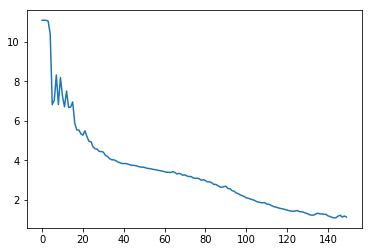

Train step : 175 & training time is 77.16380214691162 seconds.
Train step : 200 & training time is 87.74324989318848 seconds.


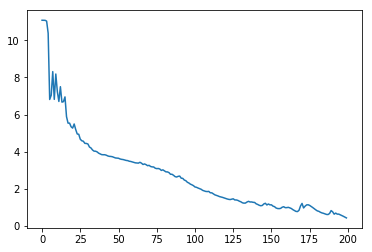

Train step : 225 & training time is 98.52079439163208 seconds.
Train step : 250 & training time is 109.09297966957092 seconds.


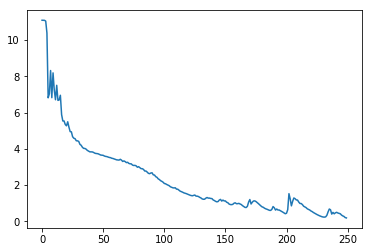

The final cost is 0.09631059
model saved in : checkpoints/909ishShortBeautyKick-blk_2-lay_12-qtz_65536-dil_256-final_step254/
Training took 111.30555081367493 seconds.


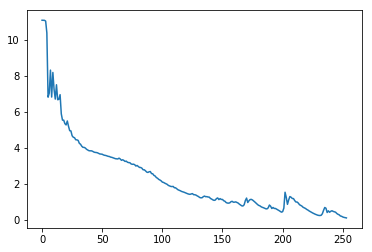

Main directory :  datasets/909ishShortBeautyKick  created 
Sample_rate directory :  datasets/909ishShortBeautyKick/sr_11025  created 
Parameters directory :  datasets/909ishShortBeautyKick/sr_11025/blk_2_lay_12_qtz_65536_dil_256_nsp_5058_step_254/  created 
Checkpoints directory  /checkpoints/sr_11025/blk_2_lay_12_qtz_65536_dil_256_nsp_5058_step_254  already exists
original wav written
Text files created
text file ready
Losses created
Making Generator : 


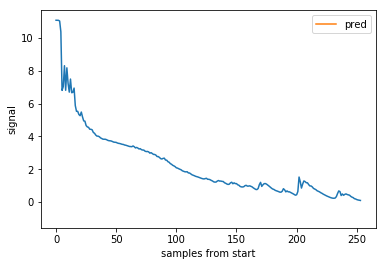

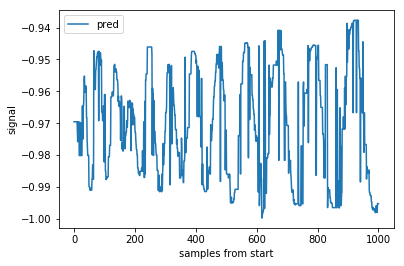

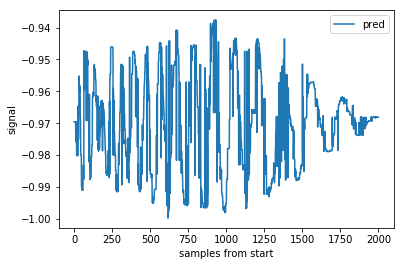

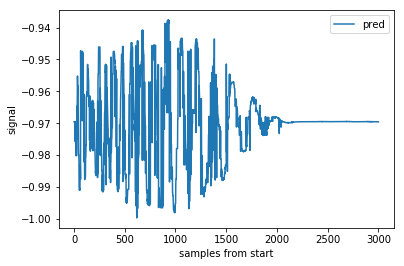

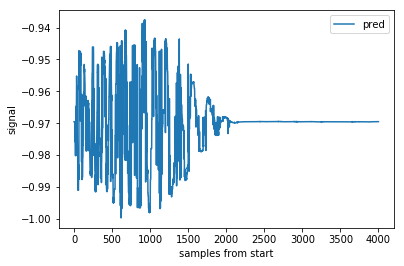

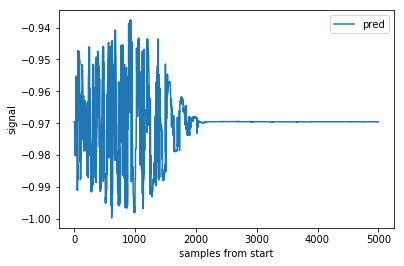

Generating took 13.09190559387207 seconds.
generated wav written


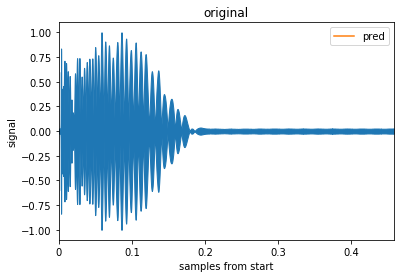

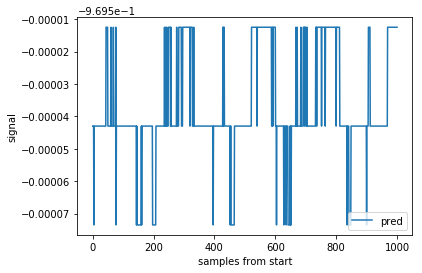

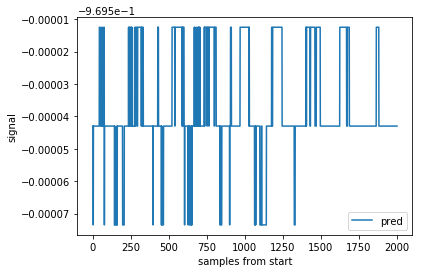

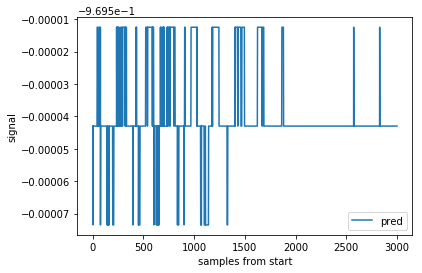

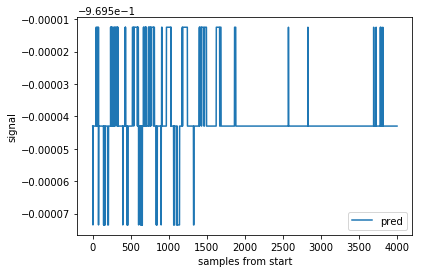

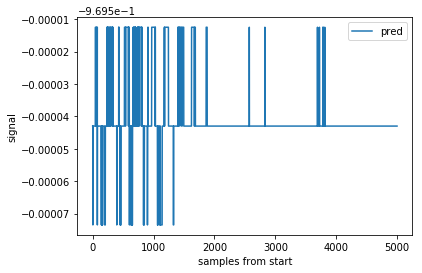

random generated wav written


In [7]:
from time import time
import datetime
import os
import numpy as np 


from wavenet.utils import make_batch
from wavenet.models import Model, Generator
import tensorflow as tf

from IPython.display import Audio
from librosa import display, decompose, output

import matplotlib.pyplot as plt
%matplotlib inline

checkpoint_dir = "/checkpoints"
server_dir = 'datasets/'
local_dir = 'datasets/'

sample_rate = 11025

Quantification = 65536
BlockList = [2]
LayersList = [12]
DilatationList = [256]
WavList = ['909ishShortBeautyKick']                       
#WavList = ['ambient','synth2','Floating_Points', 'AphexTwinDrum', '909ishShortBeautyKick', 'BassRave']

id=0

num_models = len(BlockList)*len(LayersList)*len(DilatationList)*len(WavList)

for b in BlockList :
    for l in LayersList :
        for d in DilatationList :
            for w in WavList :
                
                id = id+1
                                
                print("Starting model {} on {}, with {} blocks, {} layers, {} dilatation and {} as wav file".format(id,
                                                                                                                  num_models,
                                                                                                                  b,
                                                                                                                  l,
                                                                                                                  d,
                                                                                                                  w))

                path = 'assets/' + w +'.wav'
                duration = 2

                training_done = False

                inputs, targets = make_batch(path, sample_rate, duration=duration)
                
                Audio(inputs.reshape(inputs.shape[1]), rate=sample_rate)

                num_time_samples = inputs.shape[1]
                num_channels = 1
                gpu_fraction = 1.0
                num_classes = Quantification
                num_blocks = b
                num_layers = l
                num_hidden = d

                model = Model(id=id,
                              wav=w,
                              num_time_samples=num_time_samples,
                              num_channels=num_channels,
                              gpu_fraction=gpu_fraction,
                              num_classes=num_classes, 
                              num_blocks=num_blocks, 
                              num_layers=num_layers,
                              num_hidden=num_hidden)

                %matplotlib inline

                global_tic = time()
                train_step, losses = model.train(inputs, targets)
                global_toc = time()

                training_time = global_toc-global_tic
                print('Training took {} seconds.'.format(training_time))

                training_done = True

                plt.plot(losses)
                plt.show()

                # O(num_sample * num_layers)  => num_classes (quantification) doesn't affect the time complexity
                    # num_sample : 3s of training per second of inputs
                    #              Sample_rate=44100 => 1_second_of_traning/14000_samples

                # To save generated and original samples locally or on the server

                for directory in [local_dir] :

                    new_dir_path = directory + w 

                    sample_rate_path = '/' + 'sr_{}'.format(sample_rate)

                    if not os.path.exists(new_dir_path):
                        os.mkdir(new_dir_path)
                        print("Main directory : " , new_dir_path ,  " created ")

                    else:    
                        print("Main directory : " , new_dir_path ,  " already exists")

                    if not os.path.exists(new_dir_path + sample_rate_path):
                        os.mkdir(new_dir_path + sample_rate_path)
                        print("Sample_rate directory : " , new_dir_path + sample_rate_path,  " created ")

                    else:    
                        print("Sample_rate directory " , new_dir_path + sample_rate_path,  " already exists")

                    if training_done == True :       
                        filename = "blk_{}_lay_{}_qtz_{}_dil_{}_nsp_{}_step_{}".format(num_blocks, num_layers, num_classes, num_hidden, num_time_samples+1,train_step)

                    if training_done == False :        
                        filename = "blk_{}_lay_{}_qtz_{}_dil_{}_nsp_{}".format(num_blocks, num_layers, num_classes, num_hidden, num_time_samples+1)
                    
                    full_filename_dir =  new_dir_path + sample_rate_path  + '/' + filename + '/'
                    
                    if not os.path.exists(full_filename_dir):
                        os.mkdir(full_filename_dir)
                        print("Parameters directory : " , full_filename_dir,  " created ")
                    else:    
                        print("Parameters directory " , full_filename_dir,  " already exists")
                        
                    # Create checkpoint directory and save checkpoint
                        
                    if not os.path.exists(checkpoint_dir + sample_rate_path + '/' + filename ) == False:
                        os.mkdir(checkpoint_dir + sample_rate_path + '/' + filename )
                        print("Checkpoints directory : " , checkpoint_dir + sample_rate_path + '/' + filename,  " created ")
                    else:    
                        print("Checkpoints directory " , checkpoint_dir + sample_rate_path + '/' + filename,  " already exists")
                    
                    
                    # Write the original wav file if it doesn't exist

                    if os.path.isfile(new_dir_path + sample_rate_path + '/original_sr_{}.wav'.format(sample_rate)) == False :        
                        output.write_wav(new_dir_path + sample_rate_path + '/original_sr_{}.wav'.format(sample_rate), inputs.reshape(inputs.shape[1]), sample_rate)
                        print("original wav written")

                    else :
                        print("original wav already exists")

                    #Create and write on a txt the hyperparameters that we used
                    #if os.path.isfile(full_filename_dir + filename + '.txt') == False :
                    f = open(full_filename_dir + filename + '.txt', "w")
                    print("Text files created")

                    f.write('The sample rate is : ' + str(sample_rate) + '\n')
                    f.write('The duration is : ' + str(duration) + '\n')
                    f.write('The number of samples is : ' + str(num_time_samples+1) + '\n')
                    f.write('The quantification is : ' + str(num_classes) + '\n')
                    f.write('The number of blocks is : ' + str(num_blocks) + '\n')
                    f.write('The numbers of layers is : ' + str(num_layers) + '\n')
                    f.write('The dilatation is : ' + str(num_hidden) + '\n')
                    if training_done == True :
                        f.write('The number of train step is : ' + str(train_step) + '\n')
                        f.write('The final loss is : ' + str(losses[-1]) + '\n')
                        f.write('The training time is : ' + str(training_time) + ' seconds\n')

                    print("text file ready")
                    f.close()

                    #else:
                    #    print("Text file already exist")

                    #Save the losses as an image of the plot
                    if os.path.isfile(full_filename_dir + str(int(training_time)) + '.png') == False :
                        plt.plot(losses)
                        plt.savefig(full_filename_dir + str(int(training_time)) + '.png')
                        print('Losses created')
                    else :
                        print('Losses already exists')

                generator = Generator(model)

                # Get first sample of input
                input_ = inputs[:, 0:1, 0]

                global_tic = time()
                predictions = generator.run(input_, num_time_samples)
                global_toc = time()
                generation_time = global_toc-global_tic
                print('Generating took {} seconds.'.format(generation_time))

                plt.subplot(1, 1, 1)
                display.waveplot(inputs.reshape(inputs.shape[1]), sr=sample_rate)
                plt.title('original')

                # Write the generated wav file   
                if os.path.isfile(full_filename_dir + filename + '.wav') == False :
                    output.write_wav(full_filename_dir + filename + '.wav', predictions[0], sample_rate)
                    print("generated wav written")
                else : 
                    print("generated wav already exist with those parameters")

                global_tic = time()
                new_pred = generator.run([[np.random.randn()]], num_time_samples)
                global_toc = time()

                random_time = global_toc - global_tic
                f = open(full_filename_dir + filename + '.txt', "w")
                f.write('The random generation time is : ' + str(random_time) + ' seconds\n')
                f.write('The generation time is : ' + str(generation_time) + ' seconds\n')

                # Save the random generated file
                if os.path.isfile(full_filename_dir + filename + '_random' + '.wav') == False :
                    output.write_wav(full_filename_dir + filename + '_random' + '.wav', new_pred[0], sample_rate)
                    print("random generated wav written")
                else : 
                    print("random generated wav already exist with those parameters")
                                   
Audio(new_pred, rate=sample_rate)

The seed of the random generation is the 1044 sample, with a first value of [-0.3678554]


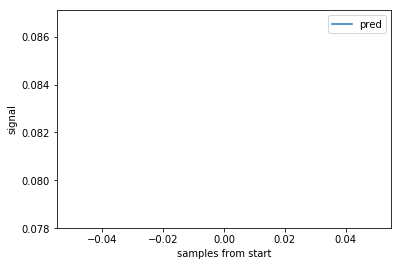

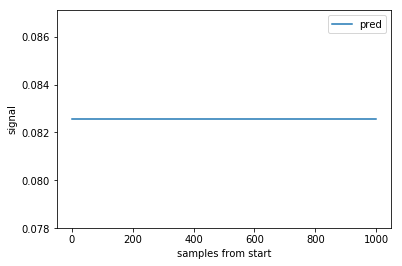

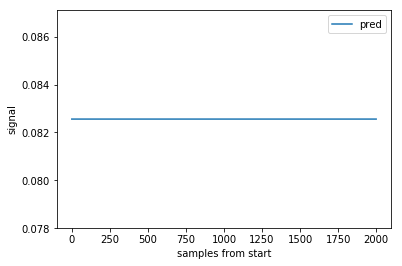

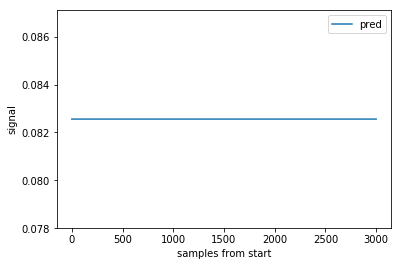

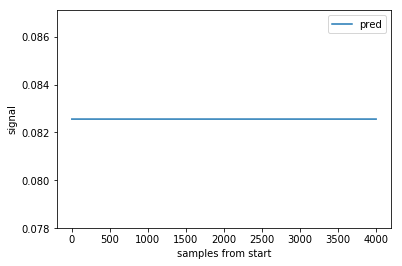

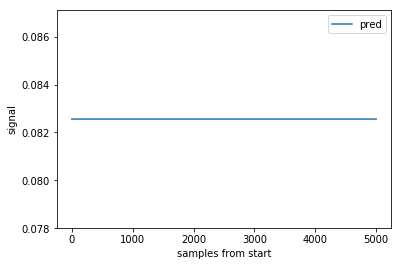

random generated wav already exist with those parameters


In [6]:
import random

seed = random.randint(0,len(inputs[0]))

print('The seed of the random generation is the ' + str(seed) + ' sample, with a first value of ' + str(inputs[0][seed]))

global_tic = time()
new_random_pred = generator.run([inputs[0][seed]], num_time_samples)
global_toc = time()

random_time = global_toc - global_tic
f = open(full_filename_dir + filename + '.txt', "w")
f.write('The random generation time is : ' + str(random_time) + ' seconds\n')
f.write('The generation time is : ' + str(generation_time) + ' seconds\n')

# Save the random generated file
if os.path.isfile(full_filename_dir + filename + '_random' + '.wav') == False :
    output.write_wav(full_filename_dir + filename + '_random' + '.wav', new_pred[0], sample_rate)
    print("random generated wav written")
else : 
    print("random generated wav already exist with those parameters")

    
Audio(new_random_pred, rate=sample_rate)